<a href="https://colab.research.google.com/github/ryanlohyr/learning-nlp/blob/main/TextClassificaation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FineTuning model for text classification

In [3]:
!pip install datasets
!pip install -U accelerate
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [4]:
from datasets import list_datasets, load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DistilBertForSequenceClassification
import matplotlib.pyplot as plt
import torch
import numpy as np

## Loading and tokenizing datasets

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 6
model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification
             .from_pretrained(model_ckpt, num_labels=num_labels)
             .to(device))


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
emotions = load_dataset("emotion")


def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

print(emotions_encoded)

# extracting the hiddten states
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
              # Extract last hidden states
    with torch.no_grad():
        # last_hidden_state = model(**inputs).last_hidden_state
        last_hidden_state = model(**inputs).logits
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [8]:
print(emotions_encoded["validation"])

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})


In [9]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [10]:
from huggingface_hub import notebook_login
notebook_login()

In [11]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                      num_train_epochs=2,
                                      learning_rate=2e-5,
                                      per_device_train_batch_size=batch_size,
                                      per_device_eval_batch_size=batch_size,
                                      weight_decay=0.01,
                                      evaluation_strategy="epoch",
                                      disable_tqdm=False,
                                      logging_steps=logging_steps,
                                      push_to_hub=True,
                                      log_level="error")

trainer = Trainer(model=model, args=training_args,
                      compute_metrics=compute_metrics,
                      train_dataset=emotions_encoded["train"],
                      eval_dataset=emotions_encoded["validation"],
                      tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.847800,0.322605,0.899000,0.898213
2,0.251500,0.222322,0.923000,0.923051


TrainOutput(global_step=500, training_loss=0.5496581878662109, metrics={'train_runtime': 240.8541, 'train_samples_per_second': 132.861, 'train_steps_per_second': 2.076, 'total_flos': 720342861696000.0, 'train_loss': 0.5496581878662109, 'epoch': 2.0})

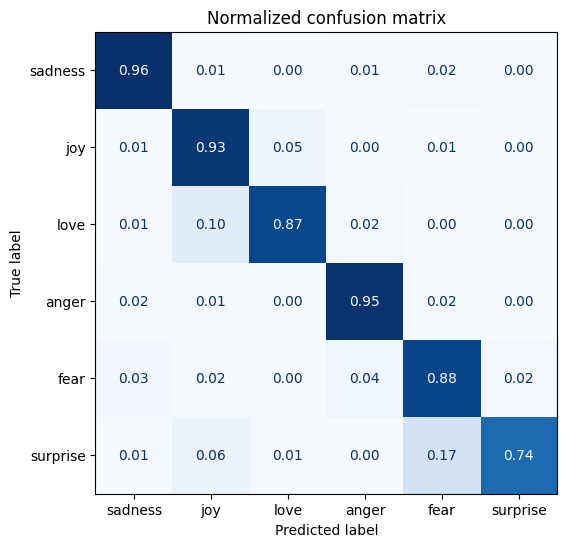

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
labels = emotions["train"].features["label"].names
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

preds_output = trainer.predict(emotions_encoded["validation"])
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

In [13]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
    reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
 # Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
        forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [19]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [20]:
 df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
465,i would eventually go in to these stores but i...,joy,fear,5.408459
1963,i called myself pro life and voted for perry w...,joy,sadness,5.316142
882,i feel badly about reneging on my commitment t...,love,sadness,5.311502
1274,i am going to several holiday parties and i ca...,joy,sadness,5.297772
765,i feel super awkward and out of place right now,joy,sadness,5.164025
1801,i feel that he was being overshadowed by the s...,love,sadness,5.152081
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.095922
1950,i as representative of everything thats wrong ...,surprise,sadness,5.065109
1662,i did not directly react to the spot fixing co...,joy,anger,4.429594
1683,i had applied for a job and they had assured m...,anger,joy,4.319752


In [21]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
632,i feel he is an terrific really worth bet,joy,joy,0.018672
1513,i have also been getting back into my gym rout...,joy,joy,0.018976
845,i already feel very glamorous have a great day...,joy,joy,0.019170
11,i was dribbling on mums coffee table looking o...,joy,joy,0.019267
604,i don t like to use the h word recklessly but ...,joy,joy,0.019267
1873,i feel practically virtuous this month i have ...,joy,joy,0.019419
1622,i feel that it was a good investment to make t...,joy,joy,0.019580
1780,ive explained that he is very creative and lov...,joy,joy,0.019657
741,i focus on little things that make me feel gla...,joy,joy,0.019826
19,i had lunch with an old friend and it was nice...,joy,joy,0.019828


The purpose of the above is so that We now know that the joy is sometimes mislabeled and that the model is most confi‐ dent about predicting the label sadness. With this information we can make targeted improvements to our dataset, and also keep an eye on the class the model seems to be very confident about.

In [22]:
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1702880801.dce856e4a0dd.608.0:   0%|          | 0.00/5.98k [00:00<?, ?B/s]

'https://huggingface.co/ryanlohyr/distilbert-base-uncased-finetuned-emotion/tree/main/'

## Refetching our model to be used in our product

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.009364573284983635}, {'label': 'LABEL_1', 'score': 0.9545745253562927}, {'label': 'LABEL_2', 'score': 0.02236946113407612}, {'label': 'LABEL_3', 'score': 0.006033236626535654}, {'label': 'LABEL_4', 'score': 0.004321050830185413}, {'label': 'LABEL_5', 'score': 0.0033371681347489357}]]


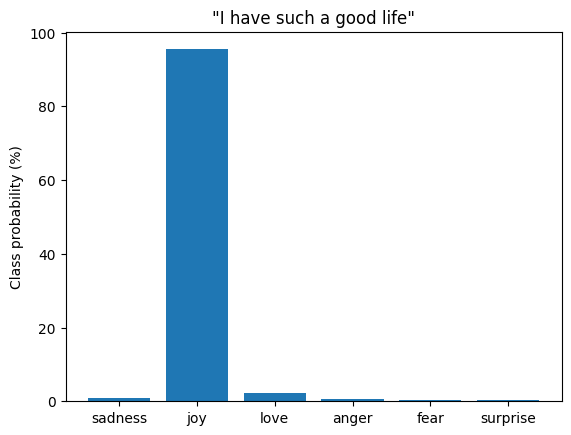

In [34]:
from transformers import pipeline
import pandas as pd
# Change `transformersbook` to your Hub username
model_id = "ryanlohyr/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)
custom_tweet = "I have such a good life"
preds = classifier(custom_tweet, return_all_scores=True)
print(preds)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()


# Learnings from this chapter

- Analytics for your data is really important
 - F1 Score, Precision, Accuracy
- See the results with highest and lowest training losses to see what type of data you need to supplement the model with
- Draw box plots, Confusion Matrixes!


# My boss wants my model in production yesterday!
In most applications, your model doesn’t just sit somewhere gathering dust—you want to make sure it’s serving predictions! When a model is pushed to the Hub, an inference endpoint is automatically created that can be called with HTTP requests. We recommend checking out the [documentation of the Inference API ](https://oreil.ly/XACF5)if you want to learn more.
  54 | Chapter 2: Text Classification
# My users want faster predictions!
We’ve already seen one approach to this problem: using DistilBERT. In Chapter 8 we’ll dive into knowledge distillation (the process by which DistilBERT was cre‐ ated), along with other tricks to speed up your transformer models.
# Can your model also do X?
As we’ve alluded to in this chapter, transformers are extremely versatile. In the rest of the book we will be exploring a range of tasks, like question answering and named entity recognition, all using the same basic architecture.
None of my texts are in English!
It turns out that transformers also come in a multilingual variety, and we’ll use them in Chapter 4 to tackle several languages at once.
# I don’t have any labels!
If there is very little labeled data available, fine-tuning may not be an option. In Chapter 9, we’ll explore some techniques to deal with this situation.